# Experiments Report

## Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

from IPython.display import IFrame
from IPython.core.display import display
from IPython.core.display import HTML

## References
**Experiments code**
* https://github.com/PrinceJavier/rl_plas_experiment

**Reference paper and code**
* PLAS: Latent Action Space for Offline Reinforcement Learning (2020)
* https://sites.google.com/view/latent-policy
* https://github.com/Wenxuan-Zhou/PLAS

**RL Environment**
* https://www.gymlibrary.dev/environments/box2d/lunar_lander/

## September 6, 2022 Update
### Data collection process
* Needed to generate own data due to lack of ready-to-use offline data for `LunarLander-v2`
* How was data generated?
    * Defined a `LunarLander-v2` environment:
        ```python
        env = gym.make(
            "LunarLander-v2",
            continuous = True,
            gravity = -10.0,
            enable_wind = True,
            wind_power = 5, # max linear wind. between 0 and 20
            turbulence_power = 1, # max rotational wind. between 0 and 2
        )
        ```
    * Trained a PPO RL model:
        ```python
        from stable_baselines3 import PPO
        model = PPO("MlpPolicy", env, verbose=1, device='cpu')
        model.learn(total_timesteps=100000)
        ```
    * Generated 1,000,000 datapoints using the trained PPO model
        * `observations` - array of observations per time step
        * `actions` - array of selected actions per time step
        * `next_observations` - array of new observations after selection action per time step
        * `rewards` - array of reward per time step
        * `terminals` - array of `True` or `False` values indicating if each round is over

### Experiments
* Trained PLAS model on the collected offline data
* For evaluation, experimented with different values of `wind_power` and `turbulence_power` - out of distribution
```python
wind_powers = np.arange(0, 21, 5)
turb_powers = np.arange(0, 2.5, 0.5)
```

### Takeaways
* The PLAS model is able to maintain positive reward across the tested environments
* It is more sensitive to `wind_power` (linear wind) than to `turbulence_power` (rotational wind)
* PLAS model has highest performance for the baseline environment (`wind_power=5` and `turbulence_power=1`) as expected
* In terms of changes in performance, the results match our expectation: "the farther away from the baseline, the lower the score." but the changes are not linear, but rather fluctuates (goes down, then goes up) as the environment parameters move farther away from the baseline
    
### Notebooks
* `data_gen_lunar_lander.ipynb` - code for the data collection process
* `experiments_lunar_lander.ipynb` - code for experiments

### Training Performance
* Average reward (30 iterations each evaluation) fluctuates widely over training iterations
* Stagnant over training iterations
* **Is there a way to make this more stable?**

<img src = "report_files/lunar_lander_plas_training_perf.png" width="400" />

### Results
* Random model is more sensitive to changes in `turbulence_power` (rotational wind strength) than to `wind_power` (linear wind strength)
* PLAS model is more sensitive to changes in `wind_power` than to `turbulence_power`. Increasing `wind_power` causes the reward to dramatically go down.
* PLAS model has highest performance for the baseline environment (`wind_power=5` and `turbulence_power=1`) as expected
* In terms of changes in performance, the results match our expectation: "the farther away from the baseline, the lower the score." but the changes are not linear, but rather fluctuates (goes down, then goes up) as the environment parameters move farther away from the baseline
    * If we fix `wind_power=0`
        * At `turbulence_power=1`, there is a reduction in reward (177 -> 143)
        * Changing further `turbulence_power=0.5 and 1.5`, there is an increase in reward (143 -> ~160)   
        * Making `turbulence_power=0 or 2` improves performance to 176
    * If we fix `wind_power=5`
        * If we reduce `turbulence_power=0.5`, there is a reduction in reward (177 -> 130)
        * If we further reduce to `turbulence_power=0`, we find an increase in reward (130 -> 160)
        * If we increase `turbulence_power=1.5`, there is a reduction in reward (177 -> 147)    
* The worst performance is at `turbulence_power=1` and `wind_power=20`. Having higher or lower `turbulence_power` than the baseline in this case actually led to better performance

In [2]:
df_results = pd.read_csv("report_files/results.csv")
df_results

,env_type,wind_power,turb_power,agent_type,avg_reward
0,baseline,5,1.0,random,-256.985877
1,baseline,5,1.0,plas,177.977649
2,out_of_dist,0,0.0,random,-234.220521
3,out_of_dist,0,0.0,plas,176.361771
4,out_of_dist,0,0.5,random,-170.462344
5,out_of_dist,0,0.5,plas,168.289977
6,out_of_dist,0,1.0,random,-306.525806
7,out_of_dist,0,1.0,plas,143.416762
8,out_of_dist,0,1.5,random,-295.215147
9,out_of_dist,0,1.5,plas,160.930513


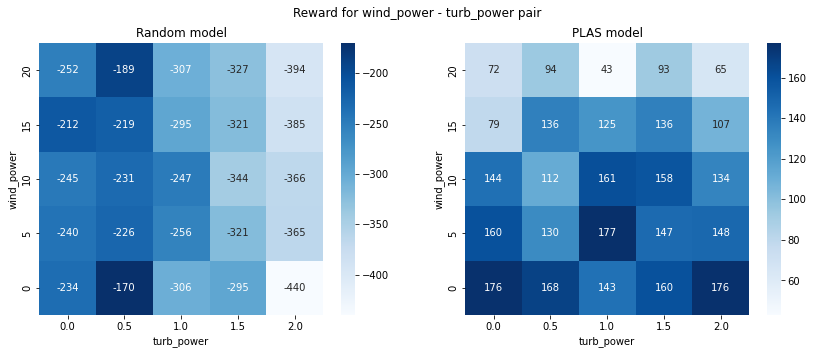

In [3]:
# heat map of turb power vs wind power
# Randp,
df_ = df_results[df_results.agent_type == 'random']
df_pivot_rand = pd.pivot_table(df_, values='avg_reward', index='wind_power', columns='turb_power').astype(int)

f, axs = plt.subplots(1, 2, figsize=(14, 5))
sns.heatmap(df_pivot_rand, annot=True, ax=axs[0], cmap='Blues', fmt='g')
axs[0].set_title("Random model")
axs[0].invert_yaxis()

# PLAS
df_ = df_results[df_results.agent_type == 'plas']
df_pivot_rand = pd.pivot_table(df_, values='avg_reward', index='wind_power', columns='turb_power').astype(int)

sns.heatmap(df_pivot_rand, annot=True, ax=axs[1], cmap='Blues', fmt='g')
plt.suptitle("Reward for wind_power - turb_power pair")
axs[1].set_title("PLAS model")
axs[1].invert_yaxis()

### Baseline environment (`w=5`, `t=1`)
We trained and evaluated the PLAS model on the same environment:
```python
env = gym.make(
    "LunarLander-v2",
    continuous = True,
    gravity = -10.0,
    enable_wind = True,
    wind_power = 5, # between 0 and 20
    turbulence_power = 1, # between 0 and 2
)
```

**Random model**

<img src = "report_files/random_baseline.gif" width="300"/>

**PLAS model**

<img src = "report_files/plas_baseline.gif" width="300"/>

### Out-of-distribution environments
We tested different combinations of `wind_power` and `turbulence_power`

In [4]:
wind_powers = np.arange(0, 21, 5)
turb_powers = np.arange(0, 2.5, 0.5)

for w in wind_powers:
    for t in turb_powers:
        if w != 5 or t != 1: # this is the baseline
            w = np.around(w, 3)
            t = np.around(t, 3)            
            
            rand_reward = np.around(df_results[(df_results.agent_type=='random') 
                                               & (df_results.wind_power == w) 
                                               & (df_results.turb_power== t)]['avg_reward'].values[0], 0)
            plas_reward = np.around(df_results[(df_results.agent_type=='plas') 
                                               & (df_results.wind_power == w) 
                                               & (df_results.turb_power== t)]['avg_reward'].values[0], 0)
            
            display(HTML(f"<h4>wind_power = {w} | turbulence_power = {t}</h4>"))
            display(HTML(f"<h5>(LEFT) Random model reward = {rand_reward} vs (RIGHT) PLAS model reward = {plas_reward}</h5>"))
            display(HTML(f"""
                        <div class="row">
                                <img src='report_files/random_w={w}_t={t}.gif' width=300> </img>
                                <img src='report_files/plas_w={w}_t={t}.gif' width=300> </img>
                        </div>
                        """))
            print()

## August 30, 2022 Update

### Experiments
* Evaluated the performance of the PLAS model on three datasets for the bullet walker simulation
    * `bullet-walker2d-random-v0-0` - collected using a random policy
    * `bullet-walker2d-medium-v0-0` - collected using a medium policy (not random but not expert)
    * `bullet-walker2d-expert-v0-0` - collected using an expert policy (well-trained model
* Environment is the default `bullet-walker2d` environment

### Takeaways
* Model trained on data from a expert policy performs the best
    * Dropped off quickly over training iterations - this is not what we want.
    * **Can this be a point of improvement?**
* Model trained on data from a medium policy can perform better than random
    * Learning is unstable over training iterations
    * **Can we somehow stabilize this?**
* Model trained on random can learn a policy better than random but the performance is not so good
    * The VAE model underfits the data
    * The best the model is able to do is keep the robot stationary and not fall down
    * This may be very difficult - extrapolating good action-state combinations from a dataset of not-so-good action-state combinations

### Notebook
* See `experiments_bulletwalker.ipynb` for details of the experiment


In [5]:
IFrame('https://docs.google.com/presentation/d/e/2PACX-1vSI_Ea2Vl7JAB8cOz42qJC3uFaW7B_-c5mqEE72DwbmVutuzuEiHxWWh9fCYSlcFs9m2MG88pvjd3xZ/embed?start=false&loop=false&delayms=3000', 
       '100%', '600')